# Focusing Data figure
Temporarily called figure 3. Could change. We want to smooth and plot bars with confidence intervals for the data in xixi's new experiments


In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
focusing = read.csv("./rawdata/focusing2.csv")
focusing %<>% rename(Substrate = Experiment)

In [3]:
focusing %<>% gather(Experiment,Concentration,Control, Add_ATP,Wait)
focusing$channel[focusing$Distance <= 100] <- 'left'
focusing$channel[focusing$Distance > 100 & focusing$Distance <= 220] <- 'center'
focusing$channel[focusing$Distance > 220] <- 'right'

In [5]:
m <- function(df,m) {
    temp <- df %>%
        bootstrap(m) %>%
#          do(augment(glm(data = ., Concentration ~ ns(Distance, df = 6)),.))
         do(augment(loess(data = ., Concentration ~ Distance, span =0.5),.))
    temp
}

In [6]:
focusing_bs <- focusing %>%
    group_by(Substrate, Experiment) %>%
    do(m(.,25))

Now we need to normalize each bootstrap sample integral to 1. We do this by sorting the distance then integrating concnetration with distances.

In [7]:
focusing_bs$channel <- 0
focusing_bs$channel[focusing_bs$Distance <= 100] <- 'left'
focusing_bs$channel[focusing_bs$Distance > 100 & focusing_bs$Distance <= 220] <- 'center'
focusing_bs$channel[focusing_bs$Distance > 220] <- 'right'
focusing_bs$channel <- factor(focusing_bs$channel, levels = c ('left','center','right'))

In [68]:
focusing_bs %<>% group_by(replicate,Substrate,Experiment,channel) %>% arrange(Distance) %>%
    mutate(concentration.channel.integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
focusing_bs %<>% group_by(replicate,Substrate,Experiment,channel) %>% arrange(Distance) %>%
    mutate(.fitted.channel.integral = t(diff(Distance)) %*% .fitted[1:(length(.fitted)-1)])
focusing_bs %<>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% 
    mutate(concentration.integral = sum(concentration.channel.integral))
focusing_bs %<>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% 
    mutate(.fitted.integral = sum(.fitted.channel.integral))
# focusing_bs %<>% ungroup() %>% group_by(Experiment,replicate,channel,Substrate) %>% 
#     mutate(concentration.normalized = sum(Integral)/mean(normalized))
focusing_bs$concentration.normalized <- focusing_bs$Concentration / focusing_bs$concentration.integral
focusing_bs$.fitted.normalized <- as.vector(focusing_bs$.fitted) / as.vector(focusing_bs$.fitted.integral)
focusing_bs$.fitted.normalized.channel.integral <- as.vector(focusing_bs$.fitted.channel.integral) / as.vector(focusing_bs$.fitted.integral )
glimpse(focusing_bs)

Observations: 25,275
Variables: 18
$ replicate                           (int) 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ Substrate                           (fctr) DG, DG, DG, DG, DG, DG, DG, DG...
$ Distance                            (dbl) 0.0000, 5.6652, 5.6652, 9.4419,...
$ Experiment                          (fctr) Control, Control, Control, Con...
$ Concentration                       (dbl) 32.0000, 35.2411, 35.2411, 39.4...
$ channel                             (fctr) left, left, left, left, left, ...
$ .fitted                             (dbl) 38.80540, 39.53860, 39.53860, 4...
$ .se.fit                             (dbl) 0.9754868, 0.8180670, 0.8180670...
$ .resid                              (dbl) -6.8053969, -4.2975048, -4.2975...
$ concentration.channel.integral      (dbl) 4341.806, 4341.806, 4341.806, 4...
$ .fitted.channel.integral            (dbl) 4328.532, 4328.532, 4328.532, 4...
$ concentration.integral              (dbl) 882660.5, 882660.5, 882660.5, 8...
$ .fitted.integra

In [69]:
alpha <- 0.05
bs_recap <- focusing_bs %>%
    group_by(Experiment, Substrate, Distance,channel) %>% 
    summarise(lo = quantile(.fitted.normalized,alpha/2), 
              hi = quantile(.fitted.normalized,1-alpha/2), 
              smooth = mean(.fitted.normalized), 
              orig = mean(concentration.normalized))
focusing_bs %<>% group_by(Experiment, Substrate, Distance,channel) %>% 
    mutate(lo = quantile(.fitted.normalized,alpha/2), hi = quantile(.fitted.normalized,1-alpha/2))

In [70]:
bychannel_bs <- focusing_bs %>% group_by(replicate,Substrate,Experiment,channel) %>% arrange(Distance) %>%
    summarise(Integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
bychannel_bs %<>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% mutate(normalized = sum(Integral))
bychannel_bs %<>% ungroup() %>% group_by(Experiment,replicate,channel,Substrate) %>% mutate(concentration = sum(Integral)/mean(normalized))
check <- bychannel_bs %>% ungroup() %>% group_by(Substrate,Experiment,replicate) %>% summarise(sum = sum(concentration))
head(check)

,Substrate,Experiment,replicate,sum
1,DG,Control,1,1
2,DG,Control,2,1
3,DG,Control,3,1
4,DG,Control,4,1
5,DG,Control,5,1
6,DG,Control,6,1


In [71]:
bychannel_recap <- bs_recap %>% 
    group_by(channel,Substrate,Experiment) %>% 
    summarise(orig = sum(orig), smooth = sum(smooth), lo = sum(lo), hi = sum(hi))

In [72]:
# glimpse(bychannel_recap)
write.csv(filter(bychannel_recap, Experiment !="Wait"),"./bychannel_recap.csv")

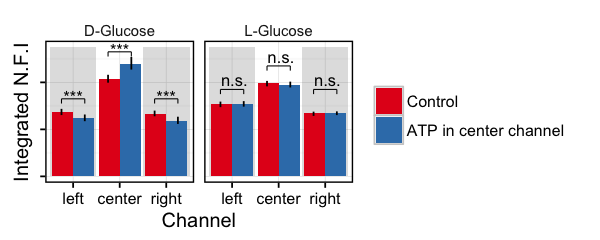

In [90]:
options(repr.plot.width = 5, repr.plot.height = 2)
integrated <- ggplot(data = filter(bychannel_recap, Experiment !="Wait") , 
                     aes(x=channel, y= smooth,fill = Experiment)) + 
    geom_bar(stat = "identity",position = "dodge") +
    xlab("Channel") +
    ylab("Integrated N.F.I") +
    facet_grid(. ~ Substrate,
        labeller = labeller(Substrate =c(DG = 'D-Glucose',LG = 'L-Glucose'))) +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
         legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
         panel.grid.major = element_line()) + 
    annotate("rect", xmin = 0.5, xmax = 1.5, ymin = 0, ymax = +.0055, alpha = .2) +
    annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
    geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
scale_fill_brewer(palette = 'Set1',labels = c("Control","ATP in center channel"))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("DG","LG"), Experiment = c("Control","Add_ATP"), 
                      ann.x = c(0.75, 0.75), ann.xend = c(1.25,1.25), ann.y = c(0.0033, 0.0037),
                      ann.yend = c(0.0033,0.0037), ann.text = c("***"," n.s."), ann.textoffset = c (0.0001,0.0004))

ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,0,1,2)
ann.data$y.offset <- c(0,0.002,0,0,0.001,0)


integrated <- integrated + 
    geom_segment(data = ann.data, size=.3,
                 aes(x = ann.x+x.offset, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset)) +
    geom_segment(data = ann.data, size = .3,
                 aes(x = ann.x+x.offset,xend=ann.x+x.offset,y=ann.y-0.0002+y.offset,yend=ann.y+y.offset)) +
    geom_segment(data = ann.data, size =.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-0.0002+y.offset,yend=ann.y+y.offset)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+.25+x.offset, y = ann.y+ann.textoffset+y.offset,label = ann.text))
                
print(integrated)

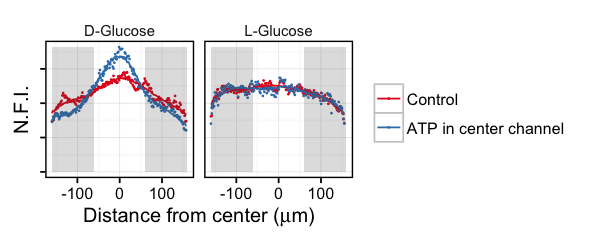

In [89]:
options(repr.plot.width = 5, repr.plot.height = 2)

raw <- ggplot(data = filter(bs_recap, Experiment != "Wait"),aes(x = Distance-160,color = Experiment)) + 
    geom_point(aes(y = orig), size = 0.1) +
    geom_line(aes(y = smooth)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(DG = 'D-Glucose',LG = 'L-Glucose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=0),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
    annotate("rect", xmin = -160, xmax = -60, ymin = 0.0000, ymax = +.000091, alpha = .2) +
    annotate("rect", xmin = 60, xmax = 160, ymin = 0.00000, ymax = +.000091, alpha = .2) +
scale_color_brewer(palette = 'Set1',labels = c("Control","ATP in center channel"))

    
print(raw)

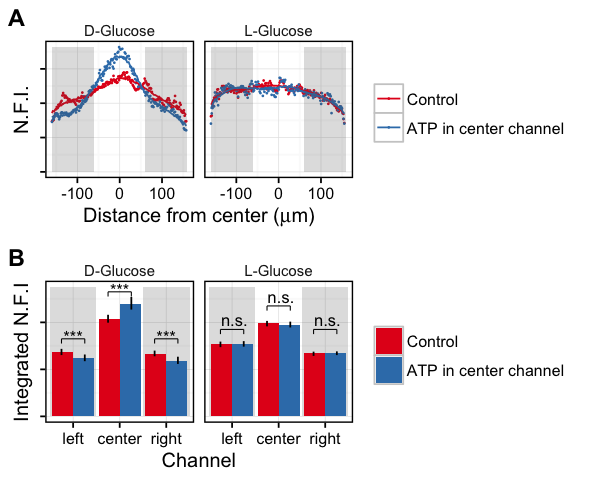

In [92]:
options(repr.plot.width = 5, repr.plot.height = 4)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 1)

In [93]:
ggsave("fig2.png",width = 5, height = 4)

In [396]:
subset <- filter(bychannel_bs,Substrate == "LG", channel == "left")
pairwise.t.test(x = subset$concentration, g =subset$Experiment)


	Pairwise comparisons using t tests with pooled SD 

data:  subset$concentration and subset$Experiment 

        Control Add_ATP
Add_ATP 0.019   -      
Wait    0.662   0.041  

P value adjustment method: holm 

In [391]:
subset <- filter(bychannel_bs,Substrate == "DG", channel == "left")
pairwise.t.test(x = subset$concentration, g =subset$Experiment)


	Pairwise comparisons using t tests with pooled SD 

data:  subset$concentration and subset$Experiment 

        Control Add_ATP
Add_ATP < 2e-16 -      
Wait    2.4e-06 < 2e-16

P value adjustment method: holm 

In [392]:
my.anova <- aov(formula = concentration.integral*10000 ~ Experiment, data = subset)

ERROR: Error in eval(expr, envir, enclos): object 'concentration.integral' not found


In [393]:
summary(my.anova)

             Df Sum Sq Mean Sq F value Pr(>F)    
Experiment    2   2842  1421.2   496.8 <2e-16 ***
Residuals   597   1708     2.9                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [394]:
pairwise.t.test(x = subset$concentration.integral, g =subset$Experiment)

ERROR: Error in tapply(x, g, mean, na.rm = TRUE): arguments must have same length


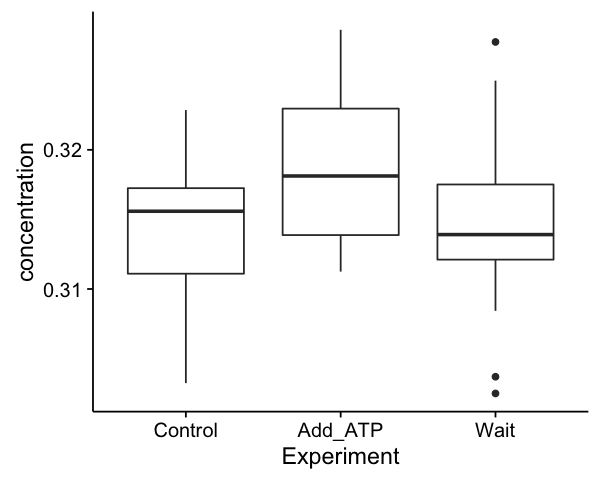

In [397]:
ggplot(data = subset, aes(x = Experiment, y=concentration)) + geom_boxplot()

In [398]:
subset <- filter(bychannel_bs,Substrate == "LG", channel == "left")
control_LG <- filter(subset, Experiment == "Control")$concentration
atp_LG <- filter(subset, Experiment == "Add_ATP")$concentration

In [399]:
mean(control_LG)

[1] 0.3141316

In [400]:
mean(atp_LG)

[1] 0.3184538

In [401]:
sd_ctrl_LG <- sd(control_LG)
sd_atp_LG <- sd(atp_LG)

In [402]:
sd_atp_LG

[1] 0.005132531

In [403]:
sd_ctrl_LG

[1] 0.005378294

In [407]:
t <- (mean(control_LG)-mean(atp_LG)) / sqrt(var(control_LG)/25+var(atp_LG)/25)

In [408]:
t

-2.906944


In [409]:
t.test(control_LG,atp_LG)


	Welch Two Sample t-test

data:  control_LG and atp_LG
t = -2.9069, df = 47.895, p-value = 0.005514
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.007311928 -0.001332520
sample estimates:
mean of x mean of y 
0.3141316 0.3184538 
